# K-Means Clustering

Tutorials:
- https://365datascience.com/tutorials/python-tutorials/pca-k-means/ 
- https://medium.com/@messenger_g/k-means-clustering-on-pca-transformed-ecological-data-python-scikit-learn-9e982a1a2b15

In [1]:
# %pip install pandas numpy seaborn matplotlib scikit-learn kneed

import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from IPython.display import display
from kneed import KneeLocator

In [2]:
# Suppress KMeans warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

# Suppress matplotlib warnings
warnings.filterwarnings("ignore", message="Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.")

# Suppress seaborn palette warnings
warnings.filterwarnings("ignore", message="The palette list has more values (10) than needed (3), which may not be intended.")

In [3]:
# Set seaborn theme
sns.set_theme(style="whitegrid")                         # set seaborn theme

In [4]:
# Define possible dataset paths.
paths = [
    '../datasets/_integrated_data/missing-pollutant-values-filled-somehow/data.csv',                    # 0 - Annual
    '../datasets/_integrated_data/missing-pollutant-values-filled-somehow/data-gendered.csv',           # 1 - Annual Gendered
    '../datasets/_integrated_data/monthly/missing-pollutant-values-filled-somehow/data.csv',            # 2 - Monthly
    '../datasets/_integrated_data/monthly/missing-pollutant-values-filled-somehow/data-gendered.csv'    # 3 - Monthly Gendered
]

# Choose the dataset to be used.
chosen_dataset = 3                                       # Choose the dataset to be used.
df = pd.read_csv(paths[chosen_dataset])                  # Read the dataset.

In [5]:
# Generate summary statistics for numerical columns.
numerical_summary_stats = df.describe().transpose()                                                         # Generate summary statistics for numerical columns.
numerical_summary_stats['missing_values'] = df.isnull().sum()                                               # Add missing values to the summary table.
numerical_summary_stats['present_values'] = df.notnull().sum()                                              # Add present values to the summary table.
numerical_summary_stats['datatype'] = df.dtypes                                                             # Add data types to the summary table.
numerical_summary_stats = numerical_summary_stats[['datatype', 'present_values', 'missing_values', 'min', '25%', '50%', '75%', 'max', 'std']]      # Select features and reorder table.

# Generate summary statistics for object columns.
object_summary_stats = df.describe(include=['O']).transpose()                                               # Generate summary statistics for object columns.
object_summary_stats['missing_values'] = df.isnull().sum()                                                  # Add missing values to the summary table.
object_summary_stats['present_values'] = df.notnull().sum()                                                 # Add present values to the summary table.
object_summary_stats['datatype'] = df.dtypes                                                                # Add data types to the summary table.
object_summary_stats = object_summary_stats[['datatype', 'present_values', 'missing_values', 'unique']]     # Select features and reorder table.

# Display the summary tables with titles.
print("Dataset Head:")                                                                                              # Display the dataset head title.
display(df.head().style.set_table_styles([{'selector': 'th', 'props': [('min-width', '100px')]}]))                  # Display the dataset head. For better visualization, set the minimum width of the table headers to 100px.

print("\nObject Summary Statistics:")                                                                               # Display the object summary statistics.
display(object_summary_stats.style.set_table_styles([{'selector': 'th', 'props': [('min-width', '100px')]}]))       # Display the object summary statistics. For better visualization, set the minimum width of the table headers to 100px.

print("\nNumerical Summary Statistics:")                                                                            # Display the numerical summary statistics.
display(numerical_summary_stats.style.set_table_styles([{'selector': 'th', 'props': [('min-width', '100px')]}]))    # Display the numerical summary statistics. For better visualization, set the minimum width of the table headers to 100px.

Dataset Head:


,year-month,lhd,CO ppm,NO pphm,NO2 pphm,OZONE pphm,PM10 µg/m³,SO2 pphm,asthma edp [f],asthma edp [m]
0,2014-07,Central Coast,0.100000,0.500000,0.600000,1.700000,10.600000,0.000000,29.800000,21.800000
1,2014-08,Central Coast,0.100000,0.300000,0.600000,1.900000,11.900000,0.000000,34.300000,32.000000
2,2014-09,Central Coast,0.100000,0.200000,0.600000,2.000000,12.500000,0.000000,28.400000,19.900000
3,2014-10,Central Coast,0.100000,0.200000,0.500000,2.300000,20.000000,0.100000,28.000000,19.500000
4,2014-11,Central Coast,0.100000,0.000000,0.300000,2.400000,20.800000,0.100000,28.000000,21.700000



Object Summary Statistics:


,datatype,present_values,missing_values,unique
year-month,object,1560,0,120
lhd,object,1560,0,13



Numerical Summary Statistics:


,datatype,present_values,missing_values,min,25%,50%,75%,max,std
CO ppm,float64,1560,0,0.000000,0.100000,0.133039,0.193861,0.456505,0.076290
NO pphm,float64,1560,0,0.000000,0.136131,0.275000,0.575000,4.576080,0.732098
NO2 pphm,float64,1560,0,0.000000,0.302769,0.484458,0.755558,2.072091,0.374287
OZONE pphm,float64,1560,0,0.623026,1.550000,1.850000,2.150000,3.213516,0.431311
PM10 µg/m³,float64,1560,0,8.095566,15.605194,18.511935,19.680863,45.265611,4.919421
SO2 pphm,float64,1560,0,0.000000,0.033193,0.068814,0.100000,0.252773,0.047696
asthma edp [f],float64,1560,0,4.600000,19.757692,28.811538,40.900000,99.900000,15.288249
asthma edp [m],float64,1560,0,2.800000,19.100000,26.600000,36.025000,105.100000,13.584746


In [6]:
# Drop the date and local health district columns
df = df.drop(columns=df.columns[:2])                                                                   # Drop the first 2 columns

# Define the possible pollutants in the dataset
possible_pollutants = ['CO ppm', 'NO pphm', 'NO2 pphm', 'OZONE pphm', 'PM10 µg/m³', 'SO2 pphm']        # Possible features

# Extract columns
pollutant_columns = [col for col in df.columns if col in possible_pollutants]                          # Extract pollutant columns
health_stat_columns = [col for col in df.columns if col not in pollutant_columns]                      # Extract health stat columns

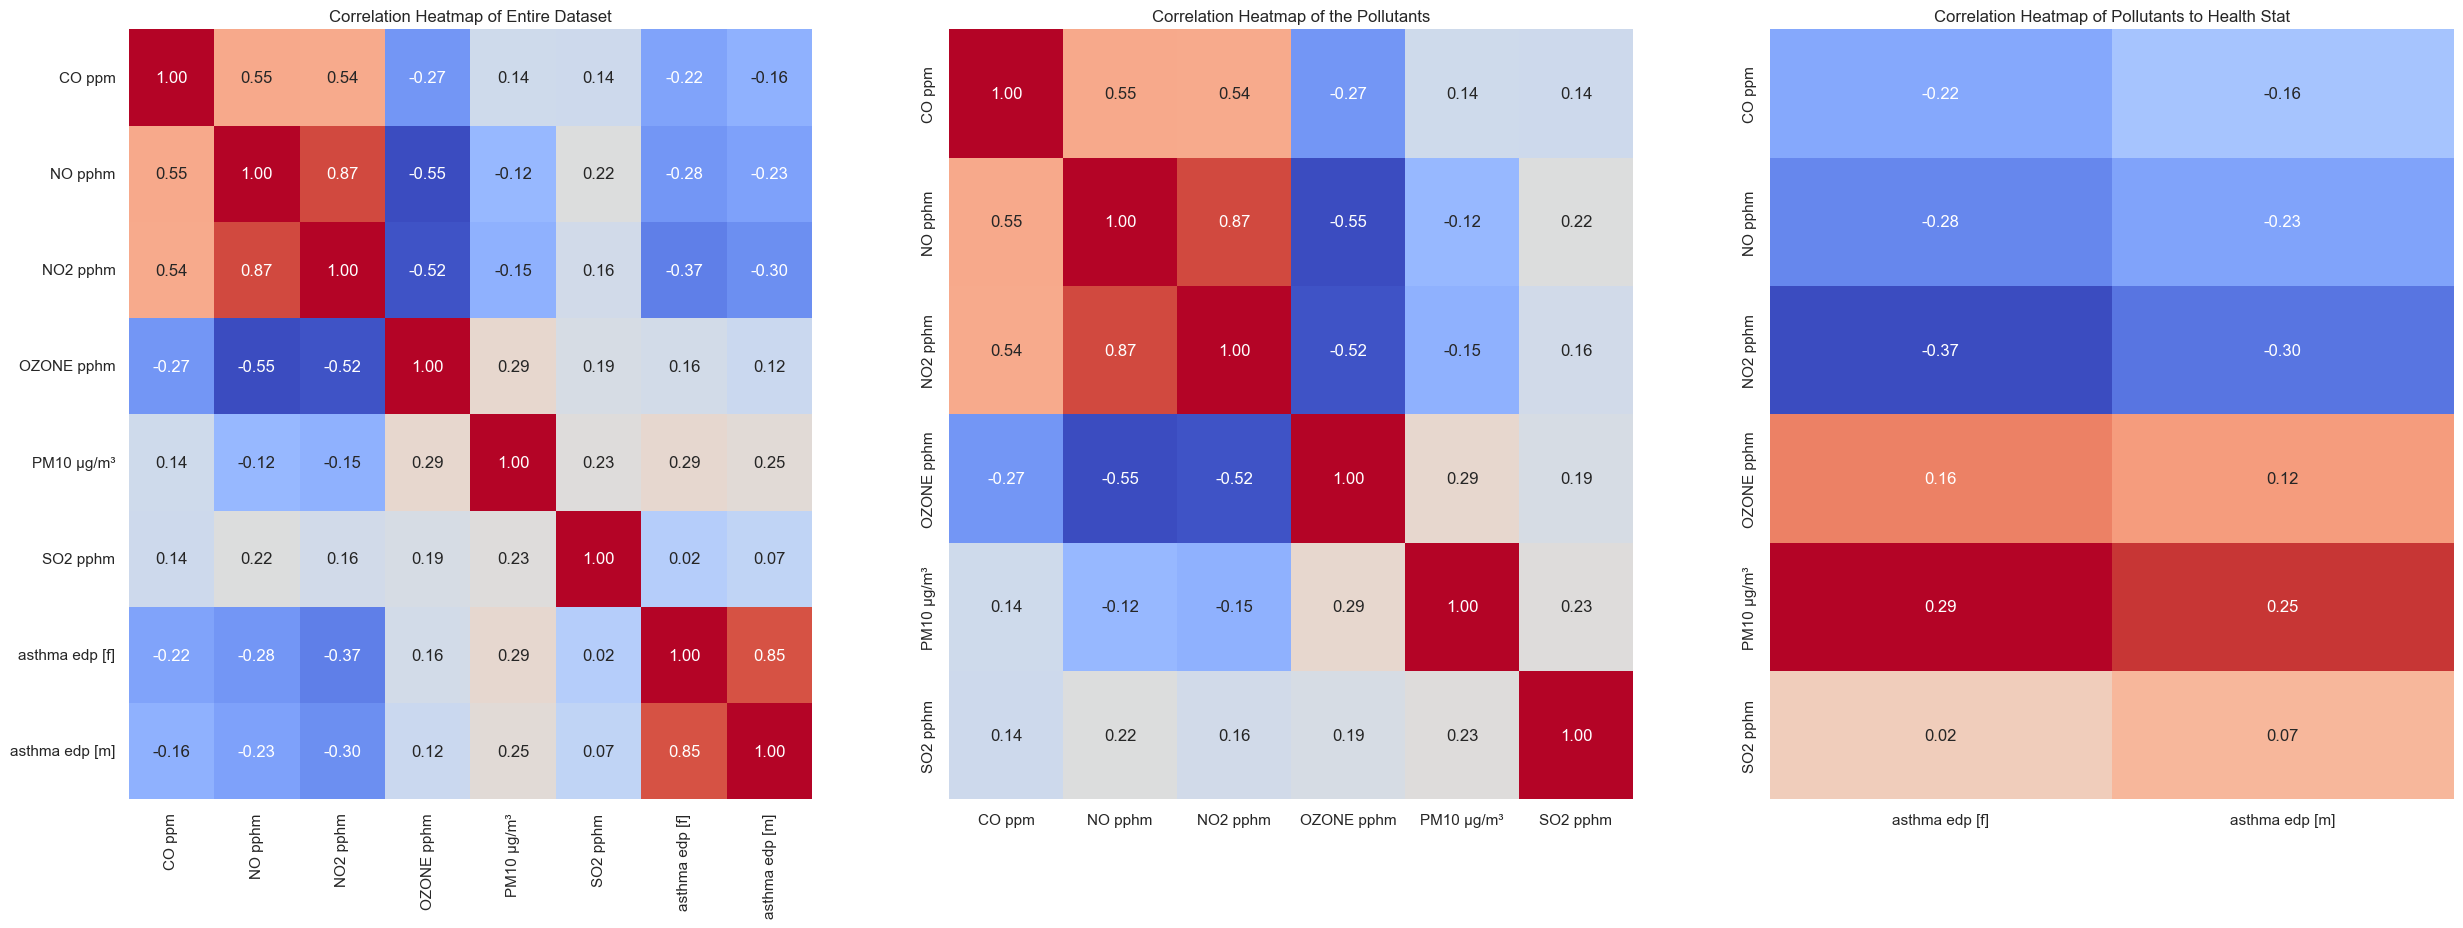

In [7]:
# Create a subplot
fig, ax = plt.subplots(1, 3, figsize=(30, 10))                                                                                    # Create a subplot

# Correlation heatmap of the entire dataset
sns.heatmap(df.corr(), ax=ax[0], cmap='coolwarm', annot=True, fmt=".2f", cbar=False)                                              # Correlation heatmap of the entire dataset
ax[0].set_title('Correlation Heatmap of Entire Dataset')                                                                          # Set the title of the first subplot

# Correlation heatmap of the health statistics
sns.heatmap(df[pollutant_columns].corr(), ax=ax[1], cmap='coolwarm', annot=True, fmt=".2f", cbar=False)                           # Correlation heatmap of the health statistics
ax[1].set_title('Correlation Heatmap of the Pollutants')                                                                          # Set the title of the second subplot

# Correlation heatmap of pollutant columns to health stat column
pollutant_health_corr = df[pollutant_columns + health_stat_columns].corr().loc[pollutant_columns, health_stat_columns]            # Correlation heatmap of pollutant columns to health stat column
sns.heatmap(pollutant_health_corr, ax=ax[2], cmap='coolwarm', annot=True, fmt=".2f", cbar=False)                                  # Correlation heatmap of pollutant columns to health stat column
ax[2].set_title('Correlation Heatmap of Pollutants to Health Stat')                                                               # Set the title of the third subplot

# Display the visualization
plt.show()                                                                                                                        # Display the visualization

In [8]:
# Scale pollutant data.
scaler = StandardScaler()                                                               # Create a scaler
pollutant_columns_scaled = scaler.fit_transform(df[pollutant_columns])                  # Scale pollutant columns

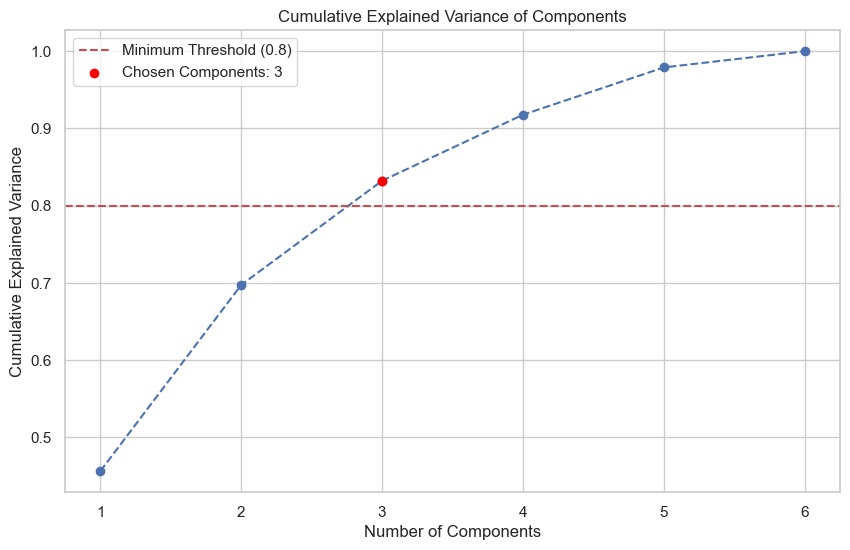

In [9]:
# Find the optimal number of clusters.
pca = PCA()                                                       # Create a PCA object
pca.fit(pollutant_columns_scaled)                                 # Fit the PCA object to the scaled pollutant columns
explained_variance = pca.explained_variance_ratio_                # Extract the explained variance of components

# Print the explained variance of components.
cumulative_variance = 0                                           # Set the cumulative variance to 0
n_components = None                                               # Set the number of components to None

# Find the number of components that explain at least 80% of the variance.
for i, variance in enumerate(explained_variance):                                       # Iterate over the explained variance
    cumulative_variance += variance                                                     # Add the variance to the cumulative variance
    if cumulative_variance >= 0.8 and n_components is None:                             # If the cumulative variance is at least 0.8 and the number of components is None
        n_components = i + 1                                                            # Set the number of components to the current index + 1
        break                                                                           # Break the loop

# Plot the cumulative explained variance of components.
plt.figure(figsize=(10, 6))                                                                                                                    # Create a figure
plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o', linestyle='--')                                       # Plot the cumulative explained variance
plt.xlabel('Number of Components')                                                                                                             # Set the x-axis label
plt.ylabel('Cumulative Explained Variance')                                                                                                    # Set the y-axis label
plt.title('Cumulative Explained Variance of Components')                                                                                       # Set the title
plt.axhline(y=0.8, color='r', linestyle='--', label='Minimum Threshold (0.8)')                                                                 # Add a horizontal line at 0.8
plt.scatter(n_components, explained_variance.cumsum()[n_components - 1], color='red', label=f'Chosen Components: {n_components}', zorder=5)    # Add a point at the chosen number of components
plt.legend()                                                                                                                                   # Add a legend
plt.show()                                                                                                                                     # Show the plot

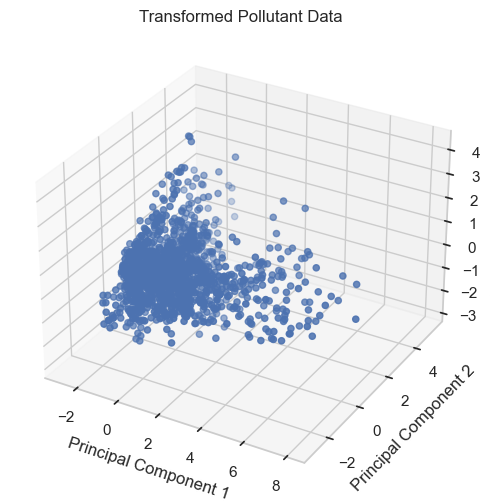

In [10]:
# Perform PCA with the chosen number of components.
pca = PCA(n_components=n_components)                                # Create a PCA object with the chosen number of components
pca.fit(pollutant_columns_scaled)                                   # Fit the PCA object to the scaled pollutant columns
pca.transform(pollutant_columns_scaled)                             # Transform the scaled pollutant columns
scores_pca = pca.transform(pollutant_columns_scaled)                # Extract the transformed pollutant columns

# Visualize the transformed data.
fig = plt.figure(figsize=(10, 6))                                   # Create a figure
ax = fig.add_subplot(111, projection='3d')                          # Create a 3D axis
ax.scatter(scores_pca[:, 0], scores_pca[:, 1], scores_pca[:, 2])    # Scatter plot the transformed data
ax.set_xlabel('Principal Component 1')                              # Set the x-axis label
ax.set_ylabel('Principal Component 2')                              # Set the y-axis label
ax.set_zlabel('Principal Component 3')                              # Set the z-axis label
ax.set_title('Transformed Pollutant Data')                          # Set the title
plt.show()                                                          # Show the plot

# TODO: Set PC3 label

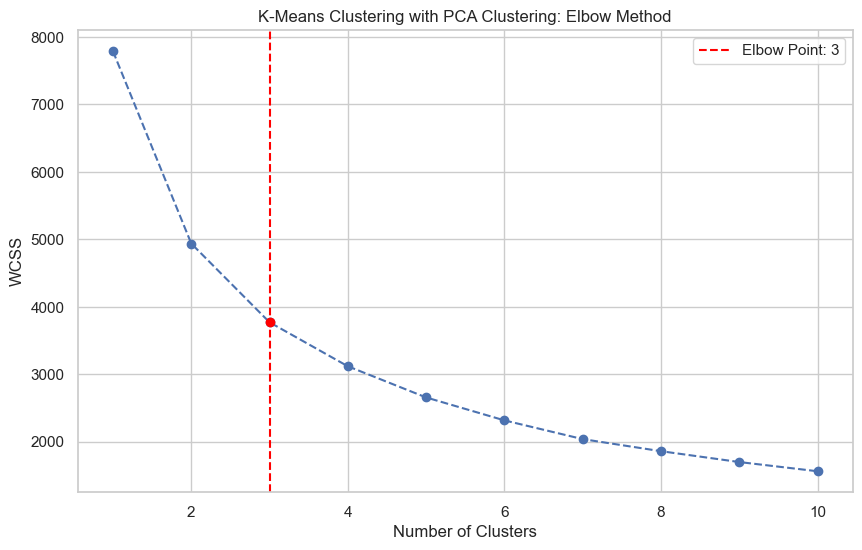

In [11]:
# Use the elbow method to find the optimal number of clusters.
wcss = []                                                                                              # Create an empty list to store the within-cluster sum of squares
for i in range(1, 11):                                                                                 # Iterate over the range from 1 to 10
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)           # Create a KMeans object with the current number of clusters
    kmeans.fit(scores_pca)                                                                             # Fit the KMeans object to the PCA scores
    wcss.append(kmeans.inertia_)                                                                       # Append the within-cluster sum of squares to the list

# Identify the elbow point using KneeLocator
kl = KneeLocator(range(1, 11), wcss, curve='convex', direction='decreasing')                           # Create a KneeLocator object
elbow = kl.elbow                                                                                       # Extract the elbow point

# Plot the elbow method graph.
plt.figure(figsize=(10, 6))                                                                            # Create a figure
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')                                               # Plot the within-cluster sum of squares
plt.xlabel('Number of Clusters')                                                                       # Set the x-axis label
plt.ylabel('WCSS')                                                                                     # Set the y-axis label
plt.title('K-Means Clustering with PCA Clustering: Elbow Method')                                      # Set the title
plt.axvline(x=elbow, color='red', linestyle='--', label=f'Elbow Point: {elbow}')                       # Add a vertical line at the elbow point
plt.scatter(elbow, wcss[elbow - 1], color='red', zorder=5)                                             # Add a point at the chosen number of clusters
plt.legend()                                                                                           # Add a legend
plt.show()                                                                                             # Show the plot

In [12]:
# Perform K-Means clustering with the optimal number of clusters.
kmeans_pca = KMeans(n_clusters=elbow, init='k-means++', max_iter=300, n_init=10, random_state=88)      # Create a KMeans object with the optimal number of clusters
kmeans_pca.fit(scores_pca)                                                                             # Fit the KMeans object to the PCA scores

# Concatenate the original dataframe with the PCA scores and cluster labels.
df = pd.concat([df.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)                          # Concatenate the original dataframe with the PCA scores

# Rename the component columns.
df.columns.values[-n_components:] = [f'component {i+1}' for i in range(n_components)]                  # Rename the columns dynamically based on the number of components

# Add a 'cluster' column to the dataframe and map the cluster labels to more descriptive names.
df['cluster'] = kmeans_pca.labels_                                                                     # Add a 'cluster' column to the dataframe
cluster_labels = {i: f'Cluster {i+1}' for i in range(elbow)}                                           # Create a dynamic mapping for cluster labels
df['cluster'] = df['cluster'].map(cluster_labels)                                                      # Map the cluster labels to more descriptive names

# Display the first few rows of the dataframe.
display(df.head().style.set_table_styles([{'selector': 'th', 'props': [('min-width', '100px')]}]))     # Display the first few rows of the dataframe. For better visualization, set the minimum width of the table headers to 100px.

,CO ppm,NO pphm,NO2 pphm,OZONE pphm,PM10 µg/m³,SO2 pphm,asthma edp [f],asthma edp [m],component 1,component 2,component 3,cluster
0,0.100000,0.500000,0.600000,1.700000,10.600000,0.000000,29.800000,21.800000,-0.005871,-2.157609,-0.079007,Cluster 1
1,0.100000,0.300000,0.600000,1.900000,11.900000,0.000000,34.300000,32.000000,-0.383837,-1.834443,0.037814,Cluster 1
2,0.100000,0.200000,0.600000,2.000000,12.500000,0.000000,28.400000,19.900000,-0.571701,-1.679237,0.090429,Cluster 1
3,0.100000,0.200000,0.500000,2.300000,20.000000,0.100000,28.000000,19.500000,-0.980618,0.826570,-0.523677,Cluster 2
4,0.100000,0.000000,0.300000,2.400000,20.800000,0.100000,28.000000,21.700000,-1.547646,0.983493,-0.386389,Cluster 2


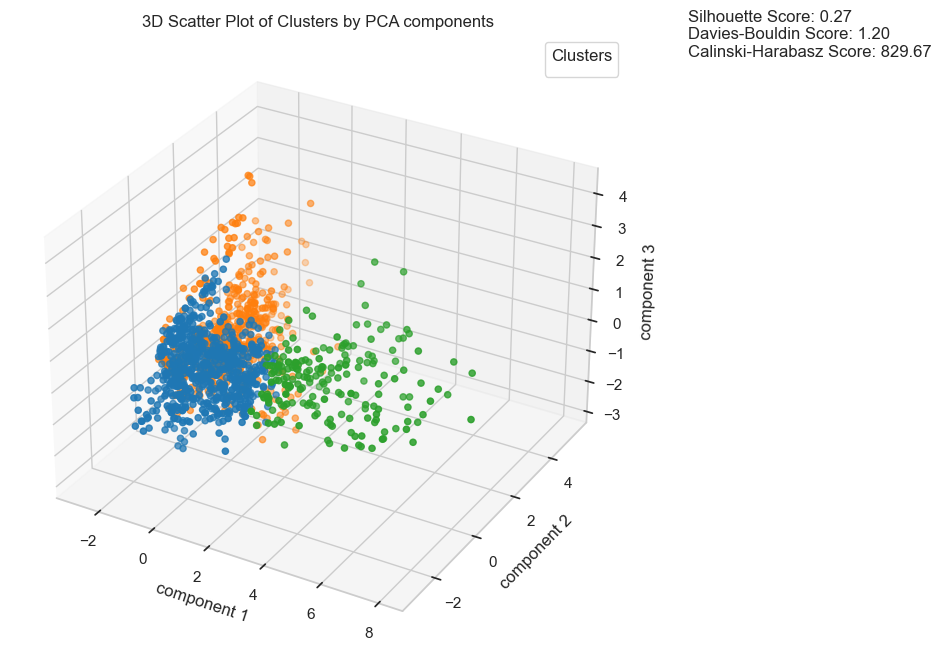

In [14]:
# Visualize the clusters in 2D.
if (n_components == 2):                                                                                # If the number of components is 2
    
    # Create a 2D scatter plot of the clusters.
    plt.figure(figsize=(10, 6))                                                                        # Create a figure
    sns.scatterplot(x='component 1', y='component 2', hue='cluster', data=df, palette='tab10')         # Create a scatter plot of the clusters
    plt.title('K-Means Clustering with PCA Clustering: 2D Visualization')                              # Set the title

    # Calculate and display metrics for each cluster
    silhouette_avg = silhouette_score(scores_pca, kmeans_pca.labels_)                                  # Calculate the silhouette score
    davies_bouldin_avg = davies_bouldin_score(scores_pca, kmeans_pca.labels_)                          # Calculate the Davies-Bouldin score
    calinski_harabasz_avg = calinski_harabasz_score(scores_pca, kmeans_pca.labels_)                    # Calculate the Calinski-Harabasz score

    # Set the text for the metrics
    metrics_text = (f"Silhouette Score: {silhouette_avg:.2f}\n"                                        # Set the text for the silhouette score
                    f"Davies-Bouldin Score: {davies_bouldin_avg:.2f}\n"                                # Set the text for the Davies-Bouldin score
                    f"Calinski-Harabasz Score: {calinski_harabasz_avg:.2f}")                           # Set the text for the Calinski-Harabasz score
    
    # Add the metrics text to the plot
    plt.text(1.1, 1, metrics_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='center')   # Add the metrics text to the plot

    # Show the plot
    plt.show()                                                                                         # Show the plot

# Visualize the clusters in 3D.
if (n_components == 3):                                                                                # If the number of components is 3
    
    # Extract the components.
    x_axis = df['component 1']                                                                         # Extract the x-axis
    y_axis = df['component 2']                                                                         # Extract the y-axis
    z_axis = df['component 3']                                                                         # Extract the z-axis

    # Set the colors for the clusters.
    palette = sns.color_palette('tab10', n_colors=3)                                                   # Create a color palette
    color_mapping = {                                                                                  # Create a color mapping for the clusters
        'Cluster 1': palette[0],                                                                       
        'Cluster 2': palette[1],
        'Cluster 3': palette[2]
    }
    colors = df['cluster'].map(color_mapping)                                                          # Map cluster labels to colors

    # Create a 3D scatter plot.
    fig = plt.figure(figsize=(10, 8))                                                                  # Create a figure
    ax = fig.add_subplot(111, projection='3d')                                                         # Add a 3D subplot
    scatter = ax.scatter(x_axis, y_axis, z_axis, c=colors)                                             # Create a scatter plot
    ax.set_xlabel('component 1')                                                                       # Set the x-axis label
    ax.set_ylabel('component 2')                                                                       # Set the y-axis label
    ax.set_zlabel('component 3')                                                                       # Set the z-axis label
    ax.set_title('3D Scatter Plot of Clusters by PCA components')                                      # Set the title
    ax.legend(*scatter.legend_elements(), title="Clusters")                                            # Add a legend

    # Calculate and display metrics for each cluster
    # TODO: Fix metrics
    silhouette_avg = silhouette_score(scores_pca, kmeans_pca.labels_)                                  # Calculate the silhouette score
    davies_bouldin_avg = davies_bouldin_score(scores_pca, kmeans_pca.labels_)                          # Calculate the Davies-Bouldin score
    calinski_harabasz_avg = calinski_harabasz_score(scores_pca, kmeans_pca.labels_)                    # Calculate the Calinski-Harabasz score

    # Set the text for the metrics
    metrics_text = (f"Silhouette Score: {silhouette_avg:.2f}\n"                                        # Set the text for the silhouette score
                    f"Davies-Bouldin Score: {davies_bouldin_avg:.2f}\n"                                # Set the text for the Davies-Bouldin score
                    f"Calinski-Harabasz Score: {calinski_harabasz_avg:.2f}")                           # Set the text for the Calinski-Harabasz score

    # Add the metrics text to the plot
    ax.text2D(1.1, 1, metrics_text, transform=ax.transAxes, fontsize=12, verticalalignment='center')   # Add the metrics text to the plot

    # Show the plot
    plt.show()                                                                                         # Show the plot

# More than 3 components
if (n_components > 3):
    print('Too many components to visualize in 2D or 3D.')                                             # Print a stating that there are too many components to visualize in 2D or 3D
    cluster_summary = df.groupby('cluster').mean()[pollutant_columns + health_stat_columns]            # Group the dataframe by cluster and calculate the mean of pollutant and health columns
    cluster_summary['Count'] = df['cluster'].value_counts()                                            # Add a 'Count' column to the cluster summary
    cluster_summary = cluster_summary.reset_index()                                                    # Reset the index of the cluster summary
    cluster_summary = cluster_summary.rename(columns={'index': 'Cluster'})                             # Rename the 'index' column to 'Cluster'
    display(cluster_summary)                                                                           # Display the cluster summary

In [15]:
# Define features
target_column = health_stat_columns[0]               # Set the target column to the first health stat column
x_axis = df[target_column]                           # Set the y-axis to the target column
y_axis = df['cluster']                               # Set the x-axis to the cluster column

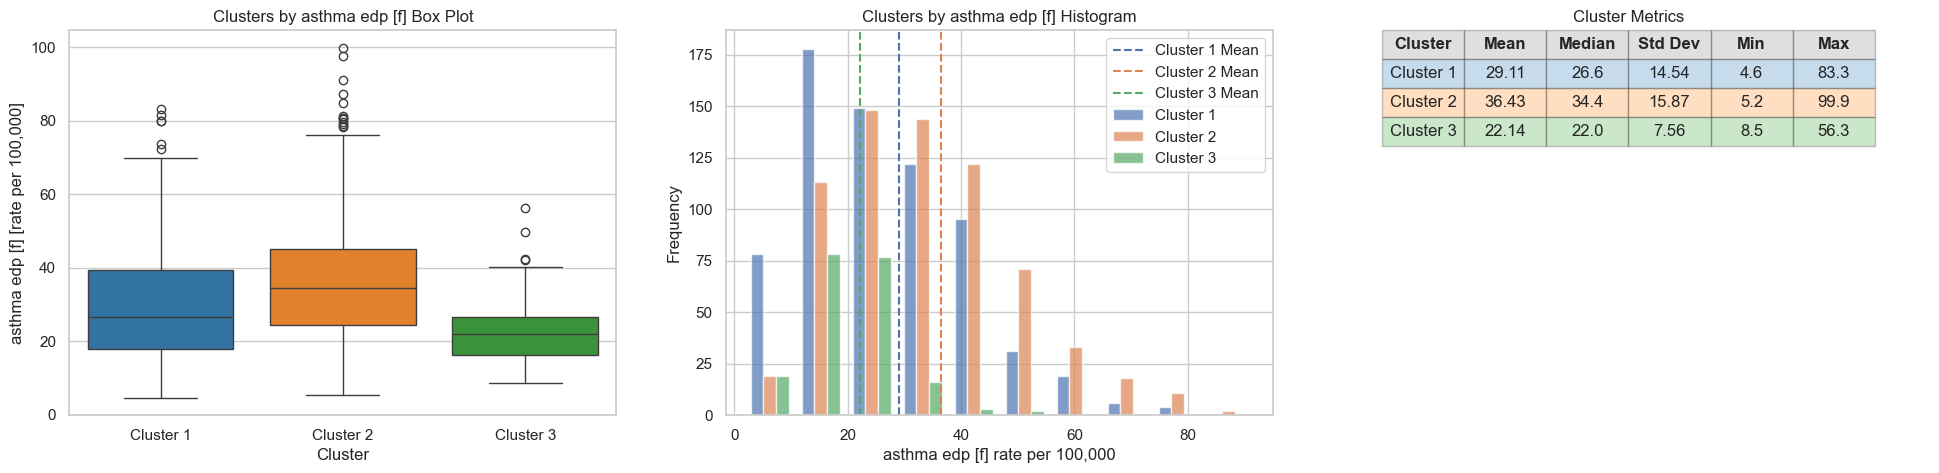

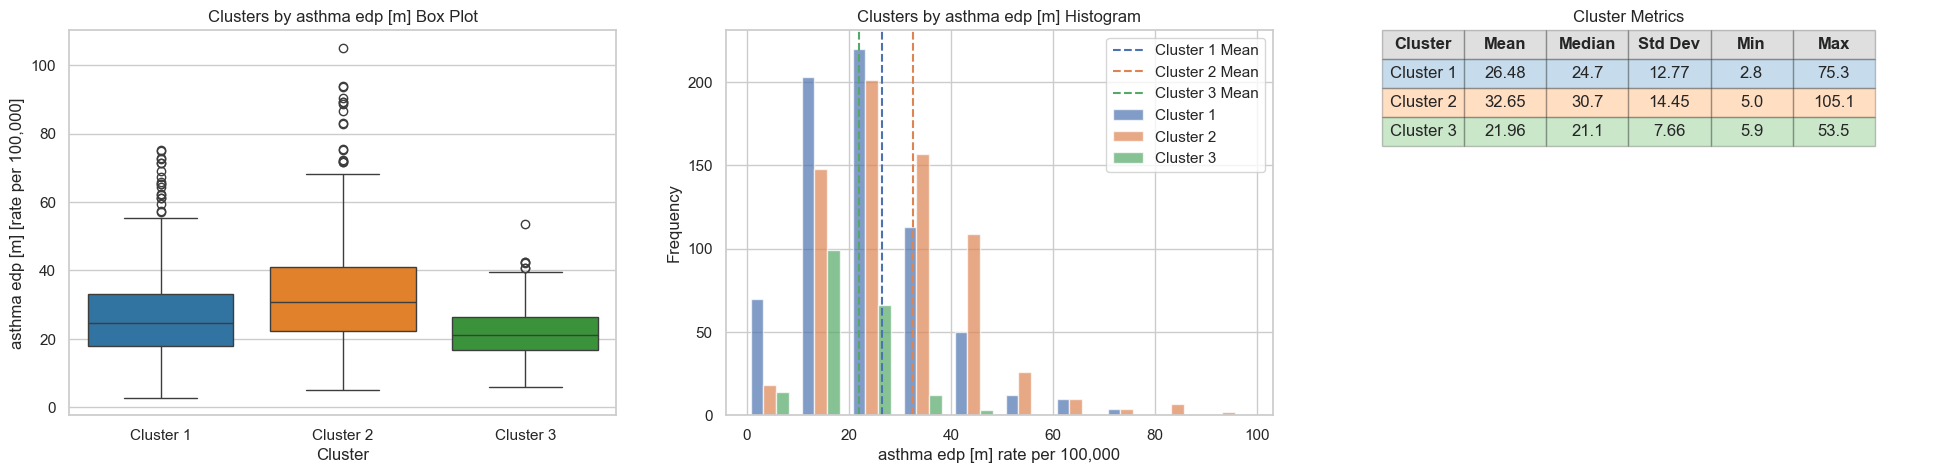

In [16]:
# Create sublplots for all health stat columns
for target_column in health_stat_columns:                                                                                 # Iterate over the health stat columns
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 5))                                                           # Create subplots

    # Boxplot
    sns.boxplot(x='cluster', y=target_column, data=df, ax=axes[0], palette='tab10', hue='cluster', dodge=False)           # Create a boxplot
    axes[0].set_title(f'Clusters by {target_column} Box Plot')                                                            # Set the title
    axes[0].set_xlabel('Cluster')                                                                                         # Set the x-axis label
    axes[0].set_ylabel(f'{target_column} [rate per 100,000]')                                                             # Set the y-axis label

    # Histogram
    min_value = df[target_column].min()                                                                                  # Extract the minimum value
    max_value = df[target_column].max()                                                                                  # Extract the maximum value
    bin_width = max(int((max_value - min_value) * 0.1), 1)                                                               # Ensure bin width is at least 1 to avoid division by zero
    bins = np.arange(int(min_value), int(max_value) + 1, bin_width)                                                      # Create bins
    clusters = df['cluster'].unique()                                                                                    # Extract unique clusters
    width = np.diff(bins)[0] / (len(clusters) + 1)                                                                       # Calculate the width of the bars

    # Plot histograms for each cluster
    for j, cluster in enumerate(clusters):                                                                               # Iterate over the clusters
        cluster_data = df[df['cluster'] == cluster][target_column]                                                       # Extract the cluster data
        cluster_mean = cluster_data.mean()                                                                               # Calculate the mean of the cluster data
        bar_positions = bins[:-1] + (j * width)                                                                          # Calculate the bar positions
        axes[1].bar(bar_positions, np.histogram(cluster_data, bins=bins)[0], width=width, label=cluster, alpha=0.7)      # Create a histogram for the cluster
        axes[1].axvline(cluster_mean, color=f'C{j}', linestyle='--', label=f'{cluster} Mean')                            # Add a vertical line for the cluster mean

    # Set the labels and title
    axes[1].set_xlabel(f'{target_column} rate per 100,000')                                                              # Set the x-axis label
    axes[1].set_ylabel('Frequency')                                                                                      # Set the y-axis label
    axes[1].set_title(f'Clusters by {target_column} Histogram')                                                          # Set the title
    axes[1].legend()                                                                                                     # Add a legend

    # Calculate and display metrics for each cluster
    metrics_data = []                                                                                                    # Create an empty list to store the metrics
    for idx, cluster in enumerate(clusters):                                                                             # Iterate over the clusters
        cluster_data = df[df['cluster'] == cluster][target_column]                                                       # Extract the cluster data
        mean = cluster_data.mean()                                                                                       # Calculate the mean
        median = cluster_data.median()                                                                                   # Calculate the median
        std_dev = cluster_data.std()                                                                                     # Calculate the standard deviation
        min_val = cluster_data.min()                                                                                     # Calculate the minimum value
        max_val = cluster_data.max()                                                                                     # Calculate the maximum value
        metrics_data.append([cluster, mean, median, std_dev, min_val, max_val])                                          # Append the metrics to the list

    # Create a dataframe from the metrics data
    metrics_df = pd.DataFrame(metrics_data, columns=['Cluster', 'Mean', 'Median', 'Std Dev', 'Min', 'Max'])              # Create a dataframe from the metrics data

    # Round the metrics to 2 decimal places
    metrics_df = metrics_df.round(2)                                                                                     # Round the metrics to 2 decimal places

    # Create table and adjust formatting
    axes[2].set_title('Cluster Metrics')                                                                                 # Set the title for the table
    axes[2].title.set_position([0.45, .9])                                                                               # Set the position of the title
    axes[2].axis('off')                                                                                                  # Turn off the axis for the table
    metrics_table = axes[2].table(                                                                                       # Create a table
        cellText=metrics_df.values,                                                                                      # Set the cell text to the values of the metrics dataframe
        colLabels=metrics_df.columns,                                                                                    # Set the column labels to the columns of the metrics dataframe
        cellLoc='center',                                                                                                # Set the cell location to the center
        loc='center', bbox=[0, 0.7, .9, 0.3]                                                                             # Set the location and bounding box
    )

    # Adjust table formatting
    metrics_table.auto_set_font_size(False)                                                                              # Disable auto font size scaling
    metrics_table.set_fontsize(12)                                                                                       # Set the font size

    # Set column width and background color
    for key, cell in metrics_table.get_celld().items():                                                                  # Iterate over the cells
        cell.set_width(0.15)                                                                                             # Set the width of the cells
        cell.set_alpha(0.25)                                                                                             # Set the opacity

        # Header row
        if key[0] == 0:                                                                                                
            cell.set_facecolor('gray')                                                                                   # Set header row to gray
            cell.set_text_props(weight='bold')                                                                           # Make headers bold 
        # Data rows
        else:
            cluster_name = metrics_df.iloc[key[0] - 1, 0]                                                                # Get the cluster name
            cell.set_facecolor(color_mapping[cluster_name])                                                              # Set the background color based on the cluster

    # Display the visualization
    plt.show()                                                                                                           # Display the plot